# Linear Regression Example

In this notebook we demonstrate  the mechanics of learning in a toy example.

We will discuss **overfitting** next lecture.

## Preliminaries

### Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize
import sklearn.datasets
import sklearn.linear_model


%matplotlib inline



### Data Directories 

Create a directory with the path below

In [5]:
raw_data_dir="../../raw/probabilisticTools"
data_dir="../../data/probabilisticTools"


### Random Seed

In [6]:
seed=2506
np.random.seed(seed)

### Get Data


we read the contents of "regression_data.csv" into a `pandas.DataFrame` object

In [7]:
data=pd.read_csv(raw_data_dir+"/regression_data.csv")
data.describe()

,X,Y
count,1000.000000,1000.000000
mean,0.021253,0.126782
std,0.581702,0.280140
min,-0.997453,-0.319775
25%,-0.472366,-0.020732
50%,0.007915,0.011379
75%,0.534149,0.108054
max,0.999876,1.243707



Let's visualize the data

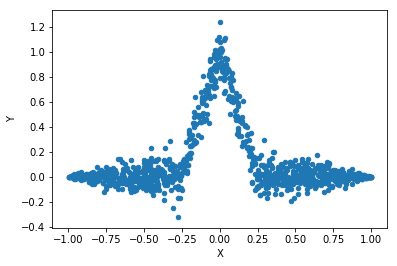

In [8]:
data.plot("X","Y",kind="scatter")


We generate `numpy` arrays named `X` and `Y` for the data of those columns

In [9]:
X=data["X"].as_matrix()
Y=data["Y"].as_matrix()
X.shape,Y.shape

((1000,), (1000,))

From now on, we will work only with the arrays `X` and `Y`

### Data Regression Model

In this notebook assume the following model
$$
     y = \sum_{d=0}^{D} h_d(x) \theta_d  + \epsilon
$$
where **$D=10$**, $\epsilon$ is a Gaussian noise term, and the *feature functions* $h_d$ are defined as follows

$$
    h_d(x) = \cos(d \pi x)
$$

[HINT] Note that $d$ runs from **0** to $D$, so there are $D+1$ features in total

You will  work out in  the homework the **maximum likelihood loss function** for this problem.
It is:

$$
    E = \frac{1}{2N}\sum_i \left( y_i -\hat{y_i} \right)^2
$$
where the predicted $Y$ is 

$$
    \hat{y}_i = \sum_d h_d(x_i)\theta_d= \sum_d H_{i,d}\theta_d
$$

The solution for $\theta$ must satisfy
$$
 (H^T H)  \theta = H^T Y
$$

**[Note]** In the max likelihood derivation there is a common variance $\sigma^2$ factor.  As a scale it does not effect the estimate value of $\theta$, so we will ignore it.

## Feature generation


We use the function [`numpy.arange`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.arange.html) 
generate and `np.array` of indexes $d=$0,1,...,D$


In [10]:
D=10
d=np.arange(0,D+1)
d

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


We generate the **phase** matrix
$$ 
    \phi_{i,d} = d \pi x_i
$$

In [11]:
phi=np.pi*X[:,np.newaxis]*d[np.newaxis,:]
phi.shape

(1000, 11)

And, finally, we generate the feature matrix for the data
$$ 
    H_{i,d} = h_d(x_i) = \cos ( \phi_{i,d})
$$

In [12]:
H=np.cos(phi)
H.shape

(1000, 11)

## Exact Solution with Numpy

2. Expressed in terms of $H$ this is just a multivariate regression problem.
1. `numpy.linalg` has a specialized function `numpy.linalg.lstsq` to solve lsq problems.
2. `numpy.linalg.solve(H,Y)` would work in most cases but it can have problems with numerical stability.
3. Computing matrix inverses is computationally expensive, and numerical ill conditioned. Avoid computing them.

In [13]:
res=np.linalg.lstsq( H,Y)
theta_exact=res[0]
theta_exact

array([ 0.12635115,  0.24109746,  0.20214756,  0.15312855,  0.10375624,
        0.05691156,  0.02238714,  0.00156388, -0.00165544,  0.00233476,
        0.01071346])

Coefficients look **very large**!


Let's look at the predicted values `Y_pred`.

In [14]:
Y_pred=np.dot(H,theta_exact)

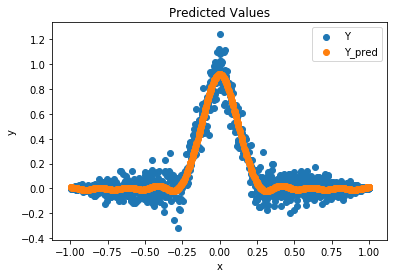

In [15]:
plt.scatter(X,Y,label="Y")
plt.scatter(X,Y_pred,label="Y_pred")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Values")
plt.legend()

The predicted function looks fairly reasonable.

Let's compute the residuals

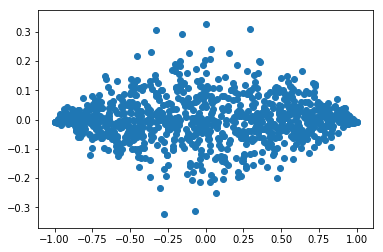

In [16]:
dY=Y-Y_pred
plt.scatter(X,dY,label="Y")


The mean square error

In [17]:
np.mean(dY**2)

0.005747690228117751

<div class="alert alert-block alert-success">Alternative Solution </div>
We could solve this is a numerically more naive fashion

$$
      (H^T H)  \theta = H^T Y
$$

so we just need to solve for $H^T Y$ given matrix $N=(H^T H)$

In [18]:
theta_exact2=np.linalg.solve(np.dot(H.T,H),np.dot(H.T,Y))
Y_sol=np.dot(H,theta_exact2)

The MSE is identical

In [19]:
dY=Y-Y_sol
np.mean(dY**2)

0.005747690228117751

An so are the coefficients $\theta$

In [20]:
for idx in range(len(theta_exact)):
    print(idx,theta_exact[idx],theta_exact2[idx])

(0, 0.12635114958515606, 0.12635114958515639)
(1, 0.24109745620219422, 0.24109745620219319)
(2, 0.20214755624055353, 0.20214755624055356)
(3, 0.15312854924332142, 0.15312854924332175)
(4, 0.1037562441486648, 0.10375624414866474)
(5, 0.056911562775099379, 0.056911562775099539)
(6, 0.022387142757264396, 0.022387142757264316)
(7, 0.0015638798660135957, 0.0015638798660135328)
(8, -0.001655435122445797, -0.0016554351224458287)
(9, 0.0023347555514943103, 0.0023347555514943428)
(10, 0.010713456171463454, 0.01071345617146359)


## Gradient Descent Optimization

We will now solve the same problem using Gradient Descent, instead of the analytic solution.


We define a python function `mse(theta,H,Y)` that computes the mean square error function given $\theta$, $H$ and $Y$

$$ 
    E = \frac{1}{2}\sum_i \left (\sum_d H_{i,d}\theta_d - Y_i\right)^2
$$

In [18]:
def mse(theta,H,Y):
    Y_pred=np.dot(H,theta)
    dY=Y_pred-Y
    return 0.5*np.mean(dY**2)


We define a python function `grad(theta,H,Y)` that computes the gradient of the error function given $\theta$, $H$ and $Y$

$$
    \frac{\partial E}{\partial \theta_d} = 
             \frac{1}{N}\sum_i H_{i,d} \left(\sum_{d'} H_{i,d'}\theta_{d'} - Y_i\right) 
$$

In [19]:
def grad(theta,H,Y):
    Y_pred=np.dot(H,theta)
    dY=(Y_pred-Y)
    return np.dot(H.T,dY)/len(H)


We use [`numpy.random.normal`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html) 
generate a random guess of the vector $\theta_0$.


In [20]:
theta0=np.random.normal(size=D+1)
theta0

array([ 1.18332114,  1.3144417 , -1.43101293, -0.90304957,  1.47576176,
       -1.11638228,  1.71375566, -0.16266391, -0.7237708 ,  0.07999463,
        0.29075605])

Before optimize we must **always** 
use the function [`scipy.optimze.check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html)
to verify numerically that `grad` is implemented correctly and it  really is the gradient of `mse` for the  $\theta_0$ guess.



In [21]:
scipy.optimize.check_grad(mse,grad,theta0,H,Y)

7.6894344883646374e-08

No we implement the 
** Steepest Descent Algorithm**

1. Set  $\eta=0.1$
1. Implement the steepest descent update rule
    $$
        \theta \leftarrow \theta - \eta \frac{\partial E}{\partial \theta}
    $$
1. Run the update rule on a loop, starting from your random guess for $\theta$. Repeat  $T=1,000$ times
1. Every 100 steps, print the step number and the current error
1. After 1,000 steps, print the final error, and the final $\theta$ parameters.

In [22]:
eta=0.1
T=1000
theta=theta0
for t in range(T):
    if (t % 100 ==0):
        print(t,mse(theta,H,Y))
    theta = theta - eta * grad(theta,H,Y)
print(T,mse(theta,H,Y))
print("theta",theta)

0 3.53194152833
100 0.00299394551826
200 0.00287385078201
300 0.00287384511435
400 0.00287384511406
500 0.00287384511406
600 0.00287384511406
700 0.00287384511406
800 0.00287384511406
900 0.00287384511406
1000 0.00287384511406
theta [ 0.12635115  0.24109746  0.20214756  0.15312855  0.10375624  0.05691156
  0.02238714  0.00156388 -0.00165544  0.00233476  0.01071346]


We compare the MSE of the steepest descent solution to the exact solution.

In [23]:
E=mse(theta,H,Y)
E_exact=mse(theta_exact,H,Y)
print("approx",E)
print("exact",E_exact)
print("diff",E-E_exact)

approx 0.00287384511406
exact 0.00287384511406
diff 0.0


We have found the same solution


In [24]:
Y_sd=np.dot(H,theta)

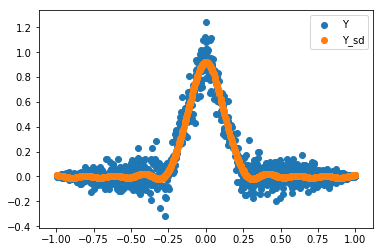

In [25]:
plt.scatter(X,Y,label="Y")
plt.scatter(X,Y_sd,label="Y_sd")
plt.legend()

## Sklearn Comparison


We can use [`sklearn.linear_model.LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
to fit our model.


In [26]:
model=sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(H,Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

Results are identical to the `numpy` solution

In [27]:
Y_sk = model.predict(H)
dY=(Y_sk-Y_pred)
np.dot(dY.T,dY)/len(dY)

0.0

The solution is stored on the model's  `coef_` variable

Results are again identical

In [28]:
print("feature, theta,theta_exact")
for idx in range(H.shape[1]):
    print(idx,model.coef_[idx],theta_exact[idx])

feature, theta,theta_exact
0 0.126351149585 0.126351149585
1 0.241097456202 0.241097456202
2 0.202147556241 0.202147556241
3 0.153128549243 0.153128549243
4 0.103756244149 0.103756244149
5 0.0569115627751 0.0569115627751
6 0.0223871427573 0.0223871427573
7 0.00156387986601 0.00156387986601
8 -0.00165543512245 -0.00165543512245
9 0.00233475555149 0.00233475555149
10 0.0107134561715 0.0107134561715


### Statmodels  Comparison

In [29]:
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We can also solve using  `statmodels` so that we appreciate the difference in emphasis between Machine Learning (`sklearn`) and Statistics Modeling `statmodels` 

In [30]:
model=sm.OLS(Y,H)
results=model.fit()

In [31]:
print("feature, theta,theta_exact")
for idx in range(H.shape[1]):
    print(idx,results.params[idx],theta_exact[idx])

feature, theta,theta_exact
0 0.126351149585 0.126351149585
1 0.241097456202 0.241097456202
2 0.202147556241 0.202147556241
3 0.153128549243 0.153128549243
4 0.103756244149 0.103756244149
5 0.0569115627751 0.0569115627751
6 0.0223871427573 0.0223871427573
7 0.00156387986601 0.00156387986601
8 -0.00165543512245 -0.00165543512245
9 0.00233475555149 0.00233475555149
10 0.0107134561715 0.0107134561715



 `statmodels` provides a goodness of fit summary (function `summary` of the results object).


In [34]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1250.
Date:                Fri, 26 Jan 2018   Prob (F-statistic):               0.00
Time:                        07:39:26   Log-Likelihood:                 1160.5
No. Observations:                1000   AIC:                            -2299.
Df Residuals:                     989   BIC:                            -2245.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1264      0.002     52.117      0.0

1. The process we specified  $y = f(x)+\epsilon$ is not exactly correct.
1. `statmodels` finds a good fit.
2. Our approximation to $f(x)$ seems reasonable, but we may be overfitting a for $d\le 7$.
3. We will analyze the situation in more detail next week.